<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AMAZON FINE FOOD REVIEWS  : RANDOM FOREST 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


**DATA SET SPLITS ** 

1. AVG_WORD2VEC : 70K TRAIN,  30K TEST
2. TFIDF_WORD2VEC : 70K TRAIN ,  30K TEST
3. BOW : 60K TRAIN,  20K CV,  20K TEST
4. TFIDF : 60K TRAIN, 20K CV,  20K TEST

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,roc_auc_score,precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import vstack
import operator
import wordcloud
import sklearn.metrics as metrics
import collections

** MOUNTING GOOGLE DRIVE TO GET THE DATA **

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## FEATURIZATION 1 : WORD2VEC

** Importing the data **

In [0]:
w2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_train.sav','rb'))
w2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_test.sav','rb'))

In [0]:
w2v_train.head()

,Vector 1,Vector 2,Vector 3,Vector 4,Vector 5,Vector 6,Vector 7,Vector 8,Vector 9,Vector 10,...,Vector 42,Vector 43,Vector 44,Vector 45,Vector 46,Vector 47,Vector 48,Vector 49,Vector 50,Score
0,0.121816,0.112731,0.522326,0.513944,0.014699,-0.510498,0.332466,-0.006182,0.510940,0.342244,...,-0.260098,-0.572254,-0.001088,0.079892,-0.092751,0.165952,0.354566,0.263851,-0.243470,1
1,0.317572,0.159626,0.343828,0.280532,0.477560,-0.579655,-0.058227,0.002837,0.070905,-0.068868,...,-0.401967,-0.649971,-0.189747,0.091126,-0.250324,-0.020535,0.567875,0.291098,-0.287811,1
2,0.113726,-0.240282,0.779548,0.906329,0.285768,-0.143818,0.310017,-0.139928,0.367076,0.384066,...,-0.153836,-0.216731,-0.155472,0.010060,-0.179123,0.395463,-0.208602,-0.294666,0.091154,1
3,0.601365,0.113279,0.712399,0.237966,0.321083,-0.329348,0.301765,-0.035661,0.460765,-0.075949,...,-0.091186,-0.206183,0.062646,0.104041,0.018641,0.299300,-0.000715,-0.171055,-0.046017,1
4,0.110524,-0.161300,0.858878,1.161848,0.425219,-0.414926,0.006795,-0.259896,0.324213,0.731779,...,-0.187014,-0.071594,-0.525720,0.221244,-0.213230,0.498298,-0.212721,-0.079328,0.490372,1


** Separating the X and Y from the datasets (train and test) ** 
1. X : Vectors 1 to 50 
2. Y : Target  Variable 

In [0]:
X_train = w2v_train.iloc[:,0:50].copy(deep=True)
X_test = w2v_test.iloc[:,0:50].copy(deep=True)
y_train = w2v_train['Score']
y_test = w2v_test['Score']

** PARAMETERS TO TUNE : ** 
1. N_estimators  : Number of base learners
2. Max_Depth : Maximum allowed depth of each decision tree
3. min_sample_leafs : Minium samples that is required to be a leaf node 

Things that are kept constant :

1. Max - Features : None  i.e Use all the features if necessary 
2. n_jobs = --1 i.e Use all the cpu cores for building the estimators 
3. oob_score = True i.e. To see the regularisation capacity of the model
4. weigths = balanced  i.e Inversely proportional to the frequencies of the labels in the dataset for class imbalance problem

In [0]:
estimators = [5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
param_grid = {"n_estimators":estimators,"max_depth":max_depth}

** GRID SEARCH ** 

1. SCORING : F1 SCORE OF NEGATIVE REVIEWS

In [0]:
model = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1,oob_score = True,max_features = None),param_grid,n_jobs =-1,scoring='roc_auc',verbose=True,cv= 2,n_iter=10)
model.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 49.1min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)

In [0]:
model.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [0]:
model.best_score_

0.8703154278650094

In [0]:
results = pd.DataFrame(model.cv_results_['params'])

In [0]:
results['Test_Score'] = model.cv_results_['mean_test_score']
results['Train_Score'] = model.cv_results_['mean_train_score']

____ 
** Visualising the results : HEATMAP ** 

** 1. Cross validated : Test Scores ** 



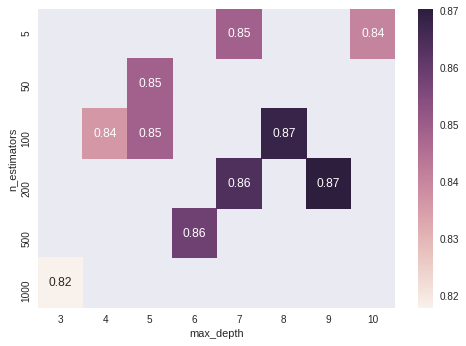

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_Score"),annot= True)

** 2. Cross validated : Train Scores ** 


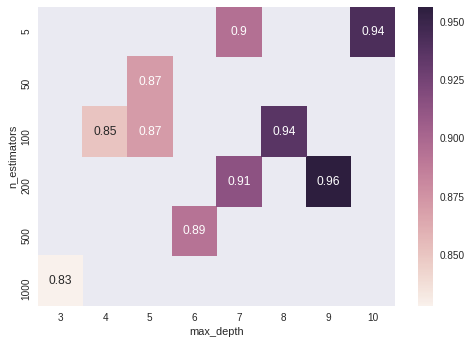

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_Score"),annot= True)

** Observations :**

Has to be written

In [0]:
model = RandomForestClassifier(n_estimators = 200,max_depth = 9,n_jobs = -1,oob_score = True,max_features = None)
model.fit(X_train,y_train)
pred = model.predict(X_test)
t_pred = model.predict(X_train)
test_error = (1 - metrics.accuracy_score(pred,y_test)) * 100
train_error = (1 - metrics.accuracy_score(t_pred,y_train)) * 100

In [0]:
print(test_error)

11.26666666666667


In [0]:
print(train_error)

7.681428571428572


In [0]:
print(classification_report(y_pred=pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.74      0.27      0.40      4101
           1       0.90      0.98      0.94     25899

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.82      0.63      0.67     30000
weighted avg       0.87      0.89      0.86     30000



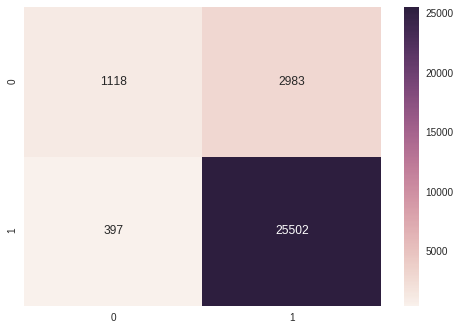

In [0]:
sns.heatmap(confusion_matrix(y_pred = pred,y_true = y_test),annot= True,fmt='d')

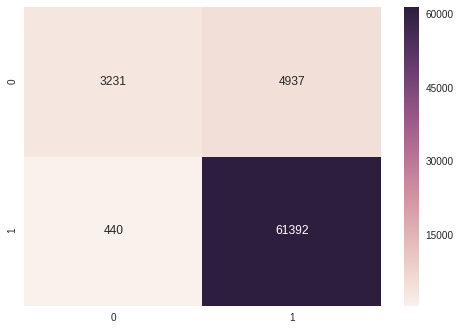

In [0]:
sns.heatmap(confusion_matrix(y_pred = t_pred,y_true = y_train),annot=True,fmt='d')

In [0]:
print("OOB_SCORE : " + str(model.oob_score_))

OOB_SCORE : 0.9022714285714286


<br>
<br>
<br>
_______




## FEATURISATION  2: BOW 

In [0]:
bow_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_bow.sav','rb'))
bow_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_bow.sav','rb'))
bow_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_bow.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
bow = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/BOW.sav','rb'))

** CONCATENATING TRAIN AND CV  TO CREATE DATASET FOR CROSS VALIDATION** 

In [0]:
X_train = vstack([bow_train,bow_cv])
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)

** DEFINING THE PARAMETERS ** 

In [0]:
estimators = [5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

param_grid = {"n_estimators":estimators,"max_depth":max_depth}

** GRID SEARCH ** 

1. SCORING : F1 SCORE OF NEGATIVE REVIEWS

In [0]:
model = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1,oob_score = True,max_features = None),param_grid,n_jobs =-1,scoring= 'roc_auc',verbose=True,cv=2)
model.fit(X_train,Y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 54.0min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)

In [0]:
model.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [0]:
results = pd.DataFrame(model.cv_results_['params'])

In [0]:
results['Test_Score'] = model.cv_results_['mean_test_score'] * 100
results['Train_Score'] = model.cv_results_['mean_train_score'] * 100
results['Difference'] = results['Train_Score'] - results['Test_Score'] 

____ 
** Visualising the results : HEATMAP ** 

** 1. Cross validated : Test Scores ** 



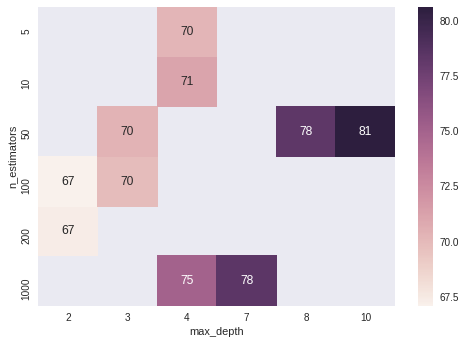

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_Score"),annot= True)

** 2. Cross validated : Train Scores ** 


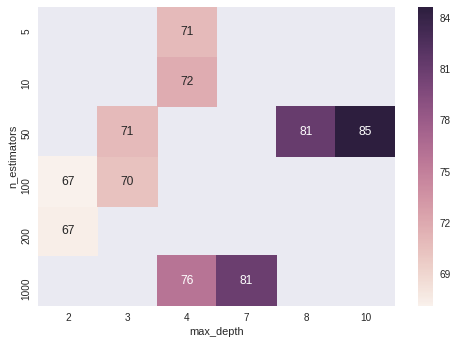

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_Score"),annot= True)

** OBSERVATIONS  : ** 

Has to be written

In [0]:
model = RandomForestClassifier(n_estimators = 50,max_depth = 10,n_jobs = -1,oob_score = True,max_features = None)
model.fit(X_train,Y_train)
pred = model.predict(bow_test)
t_pred = model.predict(X_train)
test_error = (1 - metrics.accuracy_score(pred,y_test)) * 100
train_error = (1 - metrics.accuracy_score(t_pred,Y_train)) * 100

In [0]:
print(test_error)

11.770000000000003


In [0]:
print(train_error)

9.867499999999996


In [0]:
print(classification_report(y_pred = pred,y_true = y_test))

              precision    recall  f1-score   support

           0       0.72      0.19      0.31      2674
           1       0.89      0.99      0.94     17326

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.81      0.59      0.62     20000
weighted avg       0.87      0.88      0.85     20000



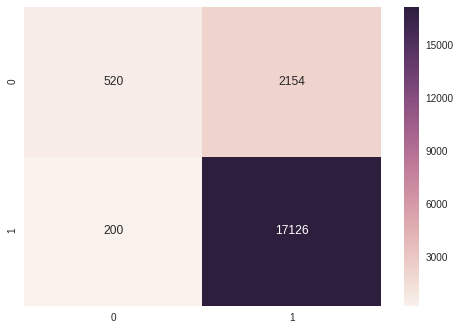

In [0]:
sns.heatmap(confusion_matrix(y_pred = pred,y_true = y_test),annot= True,fmt='d')

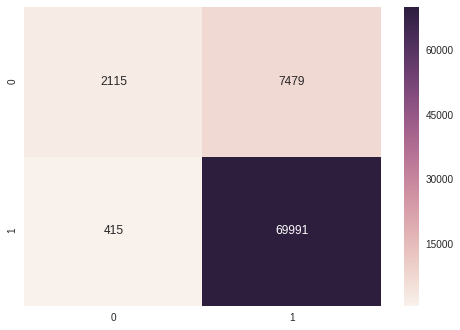

In [0]:
sns.heatmap(confusion_matrix(y_pred=t_pred,y_true =Y_train),annot=True,fmt='d')

----
<br>
** Feature importance ** 

In [0]:
features = bow.get_feature_names()

In [0]:
f_imp = dict(zip(features,model.feature_importances_))

In [0]:
top_10 = {}
for i in sorted(f_imp.items(), key=operator.itemgetter(1),reverse= True)[:10]:
  top_10[i[0]] = i[1]

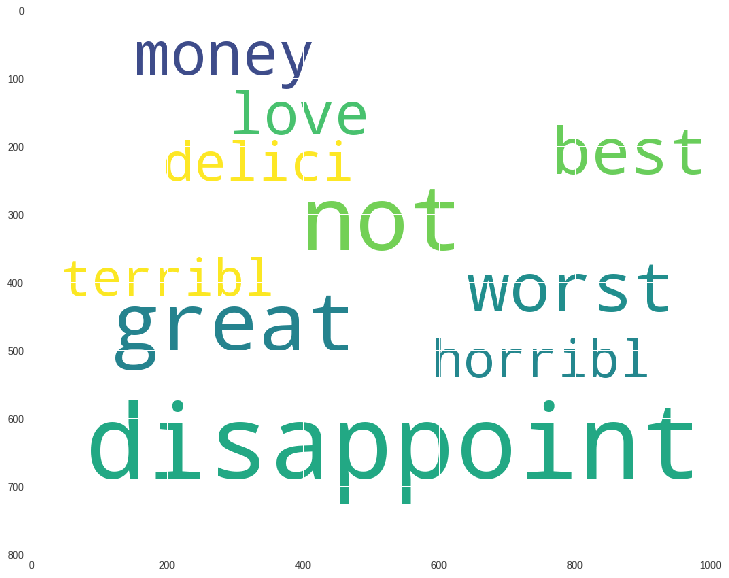

In [0]:
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_10))

<Br>
  <br>
  <Br>

<Br>
  <br>
  
  ## FEATURIZATION : TFIDF 

** Importing the data **

In [0]:
tf_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_tfidf.sav','rb'))
tf_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_tfidf.sav','rb'))
tf_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_tfidf.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
tfidf = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/tfidf.sav','rb'))

** CONCATENATING TRAIN AND CV  TO CREATE DATASET FOR CROSS VALIDATION** 

In [0]:
X_train = vstack([tf_train,tf_cv])
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)

In [0]:
X_train

<80000x29133 sparse matrix of type '<class 'numpy.float64'>'
	with 2424650 stored elements in Compressed Sparse Row format>

** DEFINING THE PARAMETERS ** 

In [0]:
estimators = [5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
param_grid = {"n_estimators":estimators,"max_depth":max_depth}

** GRID SEARCH ** 

1. SCORING : F1 SCORE OF NEGATIVE REVIEWS

In [0]:
model = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1,oob_score = True,max_features = None),param_grid,n_jobs =-1,scoring= 'roc_auc',verbose=True,cv=2)
model.fit(X_train,Y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 67.4min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)

In [0]:
model.best_params_

{'max_depth': 9, 'n_estimators': 1000}

In [0]:
results = pd.DataFrame(model.cv_results_['params'])

In [0]:
results['Test_Score'] = model.cv_results_['mean_test_score'] * 100
results['Train_Score'] = model.cv_results_['mean_train_score'] * 100
results['Difference'] = results['Train_Score'] - results['Test_Score'] 

____ 
** Visualising the results : HEATMAP ** 

** 1. Cross validated : Test Scores ** 



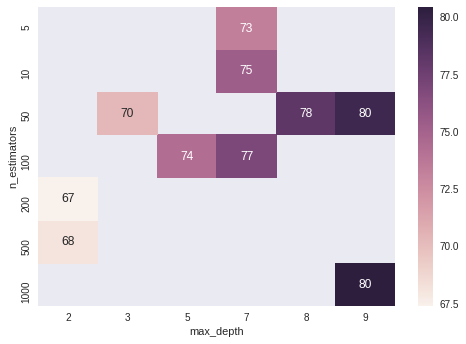

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_Score"),annot= True)

** 2. Cross validated : Train Scores ** 


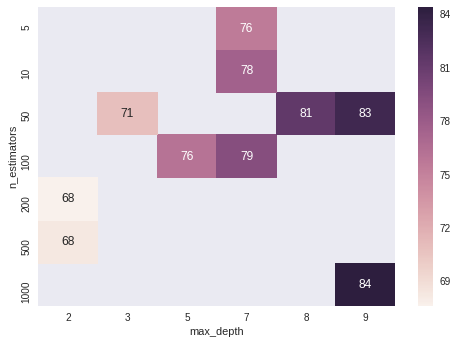

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_Score"),annot= True)

** Observations ** 

Has to be written

In [0]:
model = RandomForestClassifier(n_estimators = 1000,max_depth =9 ,n_jobs = -1,oob_score = True,max_features = None)
model.fit(X_train,Y_train)
pred = model.predict(tf_test)
t_pred = model.predict(X_train)
test_error = (1 - metrics.accuracy_score(pred,y_test)) * 100
train_error = (1 - metrics.accuracy_score(t_pred,Y_train)) * 100

In [0]:
print(test_error)

11.765000000000004


In [0]:
print(train_error)

10.033749999999998


In [0]:
print(classification_report(y_pred = pred,y_true = y_test))

              precision    recall  f1-score   support

           0       0.74      0.18      0.29      2674
           1       0.89      0.99      0.94     17326

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.82      0.59      0.61     20000
weighted avg       0.87      0.88      0.85     20000



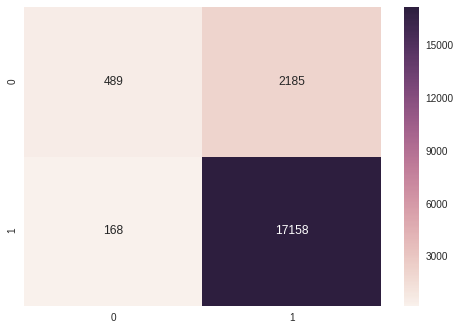

In [0]:
sns.heatmap(confusion_matrix(y_pred = pred,y_true = y_test),annot= True,fmt='d')

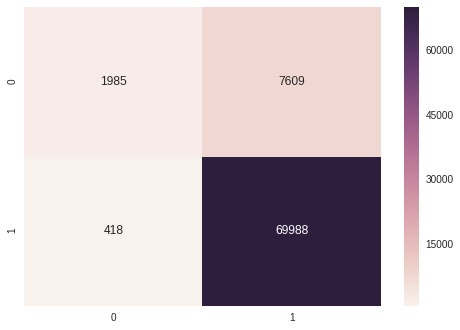

In [0]:
sns.heatmap(confusion_matrix(y_pred = t_pred,y_true =Y_train),annot=True,fmt='d')

----
<br>
** Feature importance ** 

In [0]:
features = tfidf.get_feature_names()

In [0]:
f_imp = dict(zip(features,model.feature_importances_))

In [0]:
top_10 = {}
for i in sorted(f_imp.items(), key=operator.itemgetter(1),reverse= True)[:10]:
  top_10[i[0]] = i[1]

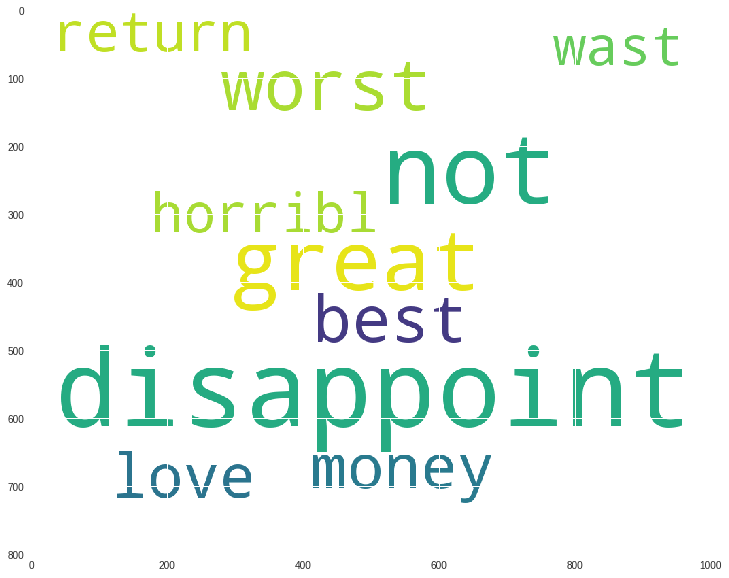

In [0]:
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_10))

<br>
<Br>
  <br>

<Br>
  <br>
  
  ## FEATURIZATION : TFIDF WORD2VEC

** Importing the data **

In [0]:
tfw2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Train_TFW2V.sav','rb'))
tfw2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Test_TFW2V.sav','rb'))

In [0]:
X_train = tfw2v_train.iloc[:,0:50].copy(deep=True)
X_test = tfw2v_test.iloc[:,0:50].copy(deep=True)
Y_train = tfw2v_train['Score']

y_test = tfw2v_test['Score']

 **DEFINING THE PARAMETERS GRID : **

In [0]:
estimators = [5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
param_grid = {"n_estimators":estimators,"max_depth":max_depth}

** GRID SEARCH ** 

1. SCORING : F1 SCORE OF NEGATIVE REVIEWS

In [0]:
model = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1,oob_score = True,max_features = None),param_grid,n_jobs =-1,scoring= 'roc_auc',verbose=True,cv=2)
model.fit(X_train,Y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 50.9min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)

In [0]:
model.best_params_

{'max_depth': 8, 'n_estimators': 1000}

In [0]:
results = pd.DataFrame(model.cv_results_['params'])

In [0]:
results['Test_Score'] = model.cv_results_['mean_test_score'] * 100
results['Train_Score'] = model.cv_results_['mean_train_score'] * 100
results['Difference'] = results['Train_Score'] - results['Test_Score'] 

____ 
** Visualising the results : HEATMAP ** 

** 1. Cross validated : Test Scores ** 



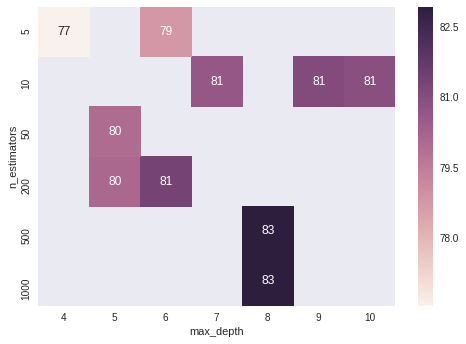

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_Score"),annot= True)

** 2. Cross validated : Train Scores ** 


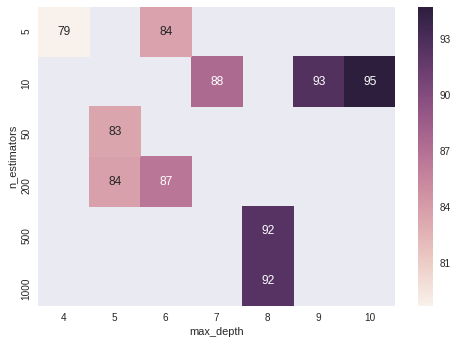

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_Score"),annot= True)

<br> <br>
** Observations ** 

 Has to be written

In [0]:
model = RandomForestClassifier(n_estimators = 1000,max_depth = 8,n_jobs = -1,oob_score = True,max_features = None)
model.fit(X_train,Y_train)
pred = model.predict(X_test)
t_pred = model.predict(X_train)
test_error = (1 - metrics.accuracy_score(pred,y_test)) * 100
train_error = (1 - metrics.accuracy_score(t_pred,Y_train)) * 100

In [0]:
print(test_error)

12.56666666666667


In [0]:
print(train_error)

10.08


In [0]:
print(classification_report(y_pred=pred,y_true = y_test))

              precision    recall  f1-score   support

           0       0.71      0.14      0.23      4101
           1       0.88      0.99      0.93     25899

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.79      0.56      0.58     30000
weighted avg       0.86      0.87      0.84     30000



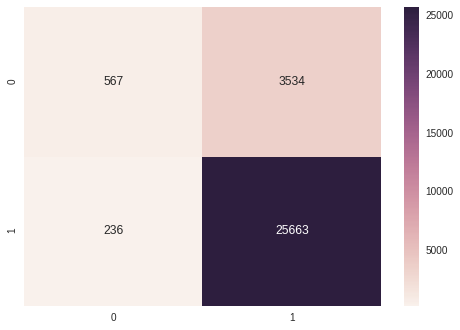

In [0]:
sns.heatmap(confusion_matrix(y_pred=pred,y_true = y_test),annot= True,fmt='d')

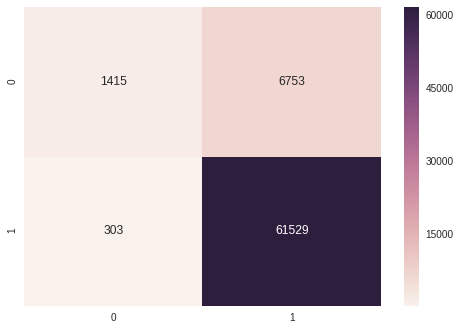

In [0]:
sns.heatmap(confusion_matrix(y_pred =t_pred,y_true=Y_train),annot=True,fmt='d')

<br>
<Br>
  <br>
  
  ## SUMMARY
  
  <br>

|FEATURIZATION| MAX-DEPTH | N_ESTIMATORS|ACCURACY   |  RECALL : NEGATIVE REVIEWS |TRAIN ERROR | TEST ERROR | DIFFERENCE|
|------|------|-----|-----|----|----|
|WORD2VEC|13|12|88.58|68%|4.06%|11.42 %|7.36|
|BOW|13|9|88.33|74%|9.42%|11.67%|2.25|
|TF-IDF|15|8|88.71|75%|8.70%|11.19%|2.49|
|TF-IDF WORD2VEC|13|8|87.57|62%|5.19%|12.43%|7.24|